## Imports

In [1]:
import mne

import matplotlib.pyplot as plt

from scipy.fft import fft

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import numpy as np

## Load subject sample data

In [2]:
file = "data/S001/S001R04.edf"
data = mne.io.read_raw_edf(file, preload=True)

info = data.info
channels = data.ch_names
annotations = data.annotations

# data = data.filter(0.01, 0.1, h_trans_bandwidth=0.01, l_trans_bandwidth=0.01)

raw_data = data.get_data()

Extracting EDF parameters from /home/ubuntu/personal-vm/EEG/data/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


## Desired channel indices

In [3]:
left_cortex_channels = [channels.index("C3.."), channels.index("C5..")]
right_cortex_channels = [channels.index("C4.."), channels.index("C6..")]

print(left_cortex_channels)
print(right_cortex_channels)

[8, 7]
[12, 13]


## Events -> slice full waveform

In [4]:
events = mne.events_from_annotations(data)
events

Used Annotations descriptions: ['T0', 'T1', 'T2']


(array([[    0,     0,     1],
        [  672,     0,     3],
        [ 1328,     0,     1],
        [ 2000,     0,     2],
        [ 2656,     0,     1],
        [ 3328,     0,     2],
        [ 3984,     0,     1],
        [ 4656,     0,     3],
        [ 5312,     0,     1],
        [ 5984,     0,     3],
        [ 6640,     0,     1],
        [ 7312,     0,     2],
        [ 7968,     0,     1],
        [ 8640,     0,     3],
        [ 9296,     0,     1],
        [ 9968,     0,     2],
        [10624,     0,     1],
        [11296,     0,     3],
        [11952,     0,     1],
        [12624,     0,     2],
        [13280,     0,     1],
        [13952,     0,     2],
        [14608,     0,     1],
        [15280,     0,     3],
        [15936,     0,     1],
        [16608,     0,     2],
        [17264,     0,     1],
        [17936,     0,     3],
        [18592,     0,     1],
        [19264,     0,     2]]),
 {'T0': 1, 'T1': 2, 'T2': 3})

## Epoch data

In [5]:
tmin, tmax = 0, 4.1
epochs = mne.Epochs(data, events[0], tmin=tmin, tmax=tmax, baseline=(0, 0))

left_rest = epochs[1].average(picks=[7]).get_data()
right_rest = epochs[1].average(picks=[13]).get_data()

left_lh = epochs[2].average(picks=[7]).get_data()
right_lh = epochs[2].average(picks=[13]).get_data()

left_rh = epochs[3].average(picks=[7]).get_data()
right_rh = epochs[3].average(picks=[13]).get_data()


Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


## Epoched time series visualization

<Figure size 640x480 with 0 Axes>

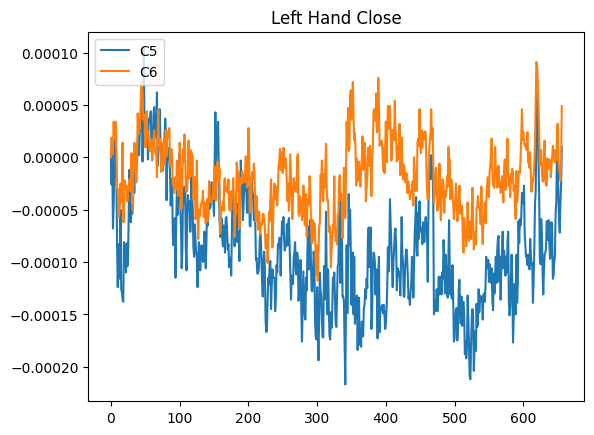

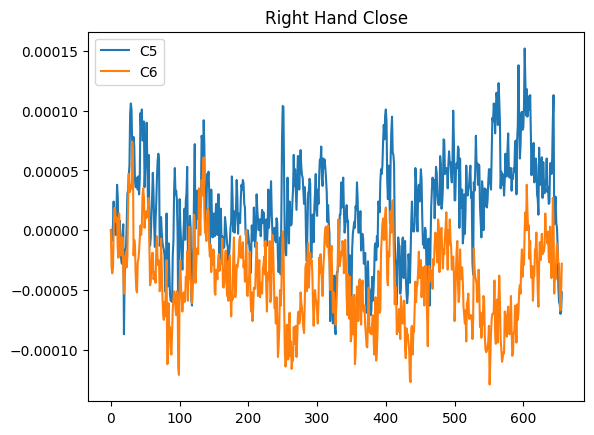

<Figure size 640x480 with 0 Axes>

In [6]:
plt.plot(left_lh[0], label="C5")
plt.plot(right_lh[0], label="C6")

plt.title("Left Hand Close")
plt.legend(loc="upper left")
plt.figure()

plt.plot(left_rh[0], label="C5")
plt.plot(right_rh[0], label="C6")

plt.title("Right Hand Close")
plt.legend(loc="upper left")
plt.figure()

## Time series reduced dim plot

In [14]:
N = 656

lh_C5_ts = []
lh_C6_ts = []

rh_C5_ts = []
rh_C6_ts = []

for event in events[0]:
    if event[2] == 2:
        lh_C5_ts += [raw_data[7,event[0]:event[0]+N]]
        lh_C6_ts += [raw_data[13,event[0]:event[0]+N]]
    elif event[2] == 3:
        rh_C5_ts += [raw_data[7,event[0]:event[0]+N]]
        rh_C6_ts += [raw_data[13,event[0]:event[0]+N]]

lh_C5_ts = np.array(lh_C5_ts)
lh_C6_ts = np.array(lh_C6_ts)

rh_C5_ts = np.array(rh_C5_ts)
rh_C6_ts = np.array(rh_C6_ts)

### PCA visualization

In [15]:
pca = PCA(n_components=2)

reduced_dims_lh = pca.fit_transform(np.concatenate((lh_C5_ts, lh_C6_ts)))
reduced_dims_rh = pca.fit_transform(np.concatenate((rh_C5_ts, rh_C6_ts)))

<Figure size 640x480 with 0 Axes>

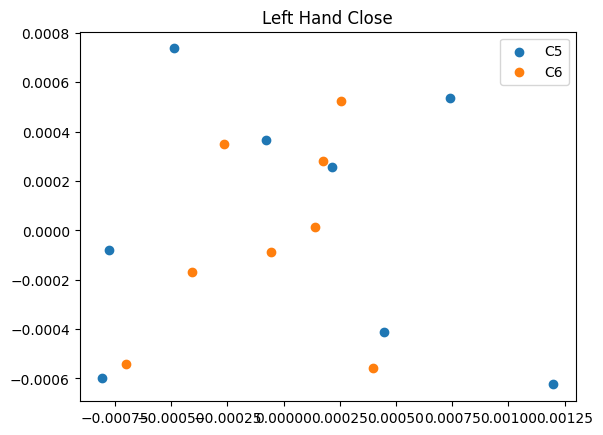

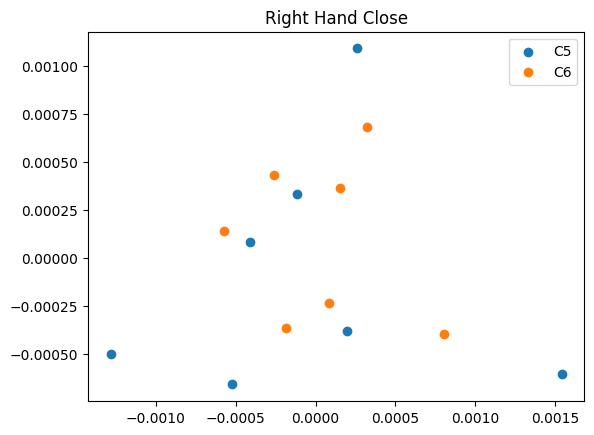

<Figure size 640x480 with 0 Axes>

In [18]:
plt.scatter(reduced_dims_lh[:8,0], reduced_dims_lh[:8,1], label="C5")
plt.scatter(reduced_dims_lh[8:,0], reduced_dims_lh[8:,1], label="C6")

plt.title("Left Hand Close")
plt.legend(loc="upper right")
plt.figure()

plt.scatter(reduced_dims_rh[:7,0], reduced_dims_rh[:7,1], label="C5")
plt.scatter(reduced_dims_rh[7:,0], reduced_dims_rh[7:,1], label="C6")

plt.title("Right Hand Close")
plt.legend(loc="upper right")
plt.figure()

## Frequency domain conversion + plot

In [69]:
left_lh_fd = fft(left_lh[0])
right_lh_fd = fft(right_lh[0])

left_rh_fd = fft(left_rh[0])
right_rh_fd = fft(right_rh[0])

N = 10
T = 1/160
x = np.linspace(0.0, N*T, N)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

<Figure size 640x480 with 0 Axes>

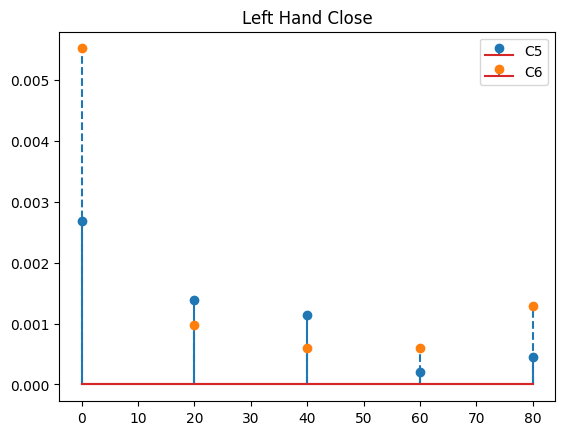

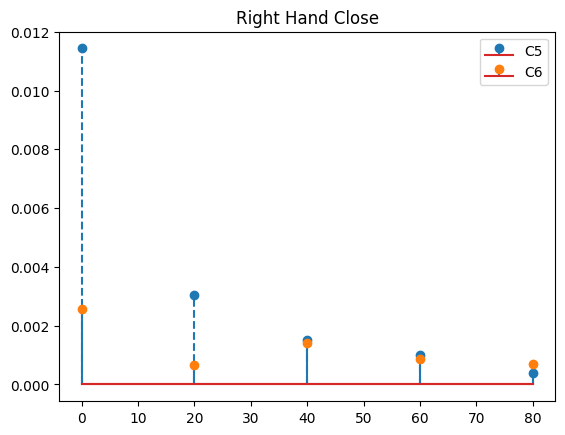

<Figure size 640x480 with 0 Axes>

In [70]:
plt.stem(xf, 2.0/N * np.abs(left_rh_fd[:N//2]), label="C5", linefmt="-")
plt.stem(xf, 2.0/N * np.abs(right_rh_fd[:N//2]), label="C6", linefmt="--")

plt.title("Left Hand Close")
plt.legend(loc="upper right")
plt.figure()


plt.stem(xf, 2.0/N * np.abs(left_lh_fd[:N//2]), label="C5", linefmt="--")
plt.stem(xf, 2.0/N * np.abs(right_lh_fd[:N//2]), label="C6", linefmt="-")

plt.title("Right Hand Close")
plt.legend(loc="upper right")
plt.figure()

## Reduced dim visualization of frequency domain

In [71]:
N = 656

lh_C5 = []
lh_C6 = []

rh_C5 = []
rh_C6 = []

for event in events[0]:
    if event[2] == 2:
        lh_C5 += [np.abs(fft(raw_data[7,event[0]:event[0]+N])[:N//2])]
        lh_C6 += [np.abs(fft(raw_data[13,event[0]:event[0]+N])[:N//2])]
    elif event[2] == 3:
        rh_C5 += [np.abs(fft(raw_data[7,event[0]:event[0]+N])[:N//2])]
        rh_C6 += [np.abs(fft(raw_data[13,event[0]:event[0]+N])[:N//2])]

lh_C5 = np.array(lh_C5)
lh_C6 = np.array(lh_C6)

rh_C5 = np.array(rh_C5)
rh_C6 = np.array(rh_C6)

### PCA visualization

In [72]:
pca = PCA(n_components=2)

reduced_dims_lh = pca.fit_transform(np.concatenate((lh_C5, lh_C6)))
reduced_dims_rh = pca.fit_transform(np.concatenate((rh_C5, rh_C6)))

<Figure size 640x480 with 0 Axes>

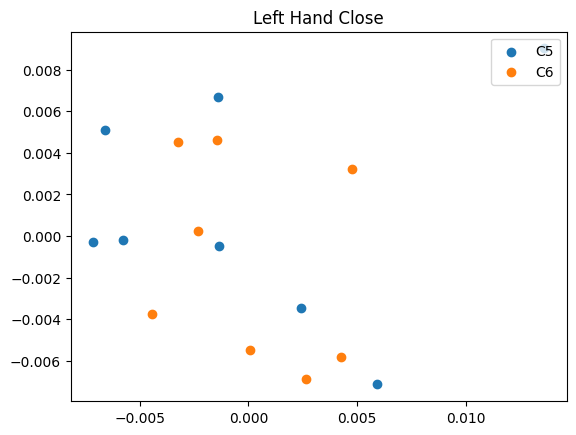

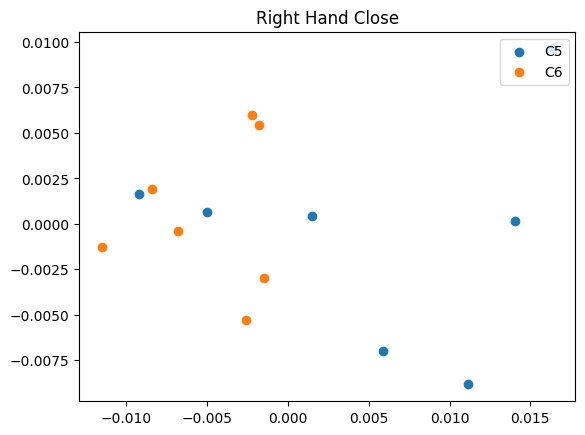

<Figure size 640x480 with 0 Axes>

In [73]:
plt.scatter(reduced_dims_lh[:8,0], reduced_dims_lh[:8,1], label="C5")
plt.scatter(reduced_dims_lh[8:,0], reduced_dims_lh[8:,1], label="C6")

plt.title("Left Hand Close")
plt.legend(loc="upper right")
plt.figure()

plt.scatter(reduced_dims_rh[:7,0], reduced_dims_rh[:7,1], label="C5")
plt.scatter(reduced_dims_rh[7:,0], reduced_dims_rh[7:,1], label="C6")

plt.title("Right Hand Close")
plt.legend(loc="upper right")
plt.figure()

### t-SNE visualization

In [74]:
tsne = TSNE(n_components=2, verbose=1, perplexity=6, n_iter=300)

tsne_lh = tsne.fit_transform(np.concatenate((lh_C5, lh_C6)))
tsne_rh = tsne.fit_transform(np.concatenate((rh_C5, rh_C6)))

[t-SNE] Computing 15 nearest neighbors...
[t-SNE] Indexed 16 samples in 0.000s...
[t-SNE] Computed neighbors for 16 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 16 / 16
[t-SNE] Mean sigma: 0.005578
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.894402
[t-SNE] KL divergence after 300 iterations: 0.876116
[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 14 samples in 0.000s...
[t-SNE] Computed neighbors for 14 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 14 / 14
[t-SNE] Mean sigma: 0.006464
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.074516
[t-SNE] KL divergence after 300 iterations: 0.905846


<Figure size 640x480 with 0 Axes>

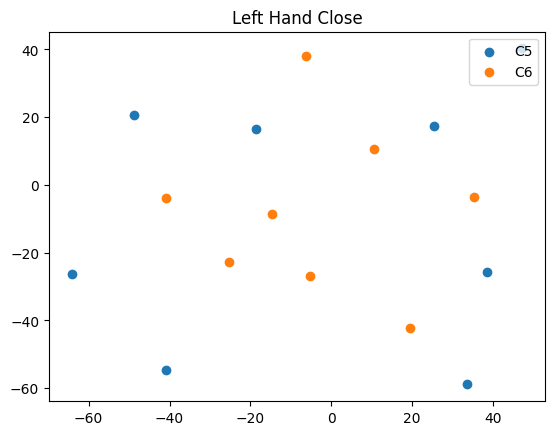

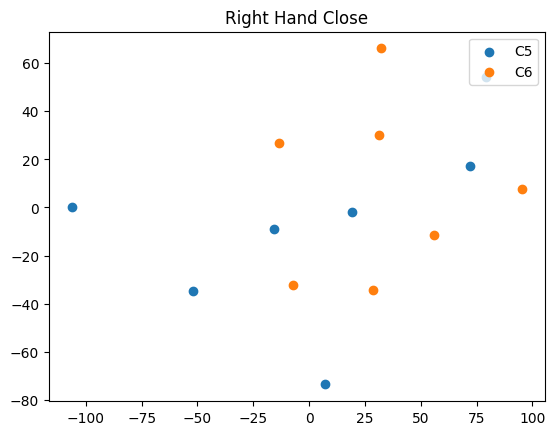

<Figure size 640x480 with 0 Axes>

In [75]:
plt.scatter(tsne_lh[:8,0], tsne_lh[:8,1], label="C5")
plt.scatter(tsne_lh[8:,0], tsne_lh[8:,1], label="C6")

plt.title("Left Hand Close")
plt.legend(loc="upper right")
plt.figure()

plt.scatter(tsne_rh[:7,0], tsne_rh[:7,1], label="C5")
plt.scatter(tsne_rh[7:,0], tsne_rh[7:,1], label="C6")

plt.title("Right Hand Close")
plt.legend(loc="upper right")
plt.figure()

## Left vs. right hand plot

In [76]:
N = 656

lh = []
rh = []

for event in events[0]:
    if event[2] == 2:
        lh += [np.concatenate((np.abs(fft(raw_data[7,event[0]:event[0]+N])[:N//2]),
                                  np.abs(fft(raw_data[13,event[0]:event[0]+N])[:N//2])))]
    elif event[2] == 3:
        rh += [np.concatenate((np.abs(fft(raw_data[7,event[0]:event[0]+N])[:N//2]),
                                  np.abs(fft(raw_data[13,event[0]:event[0]+N])[:N//2])))]

lh = np.array(lh)
rh = np.array(rh)

In [79]:
pca = PCA(n_components=2)

reduced_dims = pca.fit_transform(np.concatenate((lh, rh)))

<Figure size 640x480 with 0 Axes>

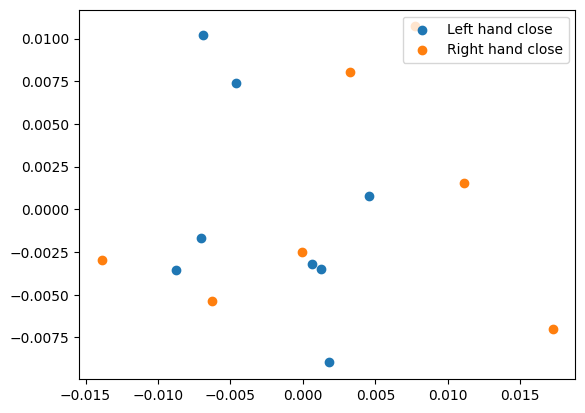

<Figure size 640x480 with 0 Axes>

In [80]:
plt.scatter(reduced_dims[:8,0], reduced_dims[:8,1], label="Left hand close")
plt.scatter(reduced_dims[8:,0], reduced_dims[8:,1], label="Right hand close")

plt.legend(loc="upper right")
plt.figure()